In [ ]:
# import libraries


import pandas as pd
import numpy as np
import urllib
from urllib.parse import unquote
import urllib.parse
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ls

drive/  sample_data/


In [ ]:
import pandas as pd

#df = pd.read_csv(zip_file.open('/content/sample_data/consumer_complain.zip'))

from zipfile import ZipFile

zip_file = ZipFile('/content/sample_data/consumer_complain.zip')

    

In [ ]:
import zipfile

zf = zipfile.ZipFile('/content/sample_data/archive.zip') # having First.csv zipped file.
df = pd.read_csv(zf.open('Consumer_Complaints.csv'))


In [ ]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,3/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,3/17/2014,Closed with explanation,Yes,No,759217
1,10/1/2016,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/5/2016,Closed with explanation,Yes,No,2141773
2,10/17/2016,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/2016,Closed with explanation,Yes,No,2163100
3,6/8/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,6/10/2014,Closed with explanation,Yes,Yes,885638
4,9/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,9/13/2014,Closed with explanation,Yes,Yes,1027760


In [ ]:
df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903983 entries, 0 to 903982
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 903983 non-null  object
 1   Product                       903983 non-null  object
 2   Sub-product                   668823 non-null  object
 3   Issue                         903983 non-null  object
 4   Sub-issue                     426386 non-null  object
 5   Consumer complaint narrative  199970 non-null  object
 6   Company public response       257981 non-null  object
 7   Company                       903983 non-null  object
 8   State                         894758 non-null  object
 9   ZIP code                      894705 non-null  object
 10  Tags                          126038 non-null  object
 11  Consumer consent provided?    375434 non-null  object
 12  Submitted via                 903983 non-null  object
 13 

In [ ]:
print(len(df)) 
df = df[['Product', 'Consumer complaint narrative']]

903983


In [ ]:
df = df[:10000]
df['cat_id'] = df['Product'].factorize()[0]

In [ ]:
from io import StringIO
category_id_df = df[['Product', 'cat_id']].drop_duplicates().sort_values('cat_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['cat_id', 'Product']].values)

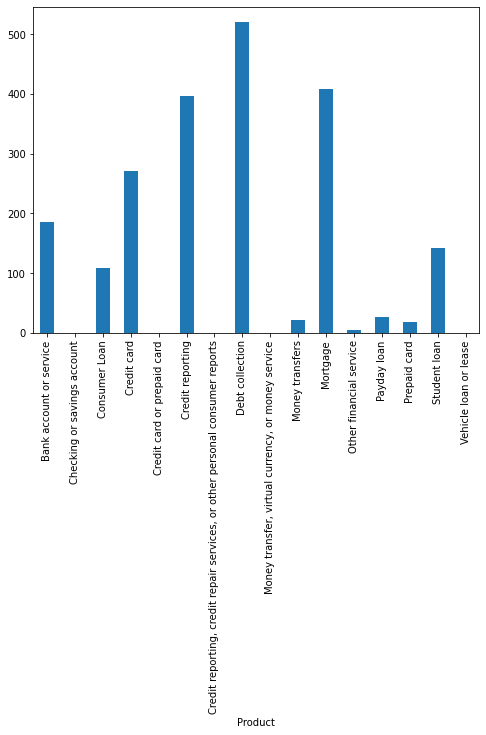

In [ ]:
fig = plt.figure(figsize=(8,6))
df.groupby('Product')['Consumer complaint narrative'].count().plot.bar(ylim=0)
plt.show()

In [ ]:

df.head()

,Product,Consumer complaint narrative,cat_id
0,Mortgage,NaN,0
1,Credit reporting,I have outdated information on my credit repor...,1
2,Consumer Loan,I purchased a new car on XXXX XXXX. The car de...,2
3,Credit card,NaN,3
4,Debt collection,NaN,4


In [ ]:
df = df.dropna(subset = ['Consumer complaint narrative'])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df['Consumer complaint narrative']).toarray()


In [ ]:
labels = df['cat_id']


In [ ]:
features.shape

(2101, 6042)

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
       . deposited
       . atm
  . Most correlated bigrams:
       . overdraft fees
       . checking account
# 'Checking or savings account':
  . Most correlated unigrams:
       . ended
       . ensure
  . Most correlated bigrams:
       . ending xxxx
       . zero balance
# 'Consumer Loan':
  . Most correlated unigrams:
       . car
       . vehicle
  . Most correlated bigrams:
       . personal loan
       . ally financial
# 'Credit card':
  . Most correlated unigrams:
       . citi
       . card
  . Most correlated bigrams:
       . annual fee
       . credit card
# 'Credit card or prepaid card':
  . Most correlated unigrams:
       . ended
       . ensure
  . Most correlated bigrams:
       . ending xxxx
       . zero balance
# 'Credit reporting':
  . Most correlated unigrams:
       . experian
       . equifax
  . Most correlated bigrams:
       . information credit
       . credit report
# 'Credit reporting, credit rep

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Consumer complaint narrative'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


In [ ]:
df[df['Consumer complaint narrative'] == "This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]

,Product,Consumer complaint narrative,cat_id
12,Debt collection,This company refuses to provide me verificatio...,4


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.472684
1,RandomForestClassifier,1,0.497619
2,RandomForestClassifier,2,0.457143
3,RandomForestClassifier,3,0.490476
4,RandomForestClassifier,4,0.430952
5,LinearSVC,0,0.814727
6,LinearSVC,1,0.814286
7,LinearSVC,2,0.802381
8,LinearSVC,3,0.816667
9,LinearSVC,4,0.778571


In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.805326
LogisticRegression        0.778661
MultinomialNB             0.682051
RandomForestClassifier    0.469775
Name: accuracy, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

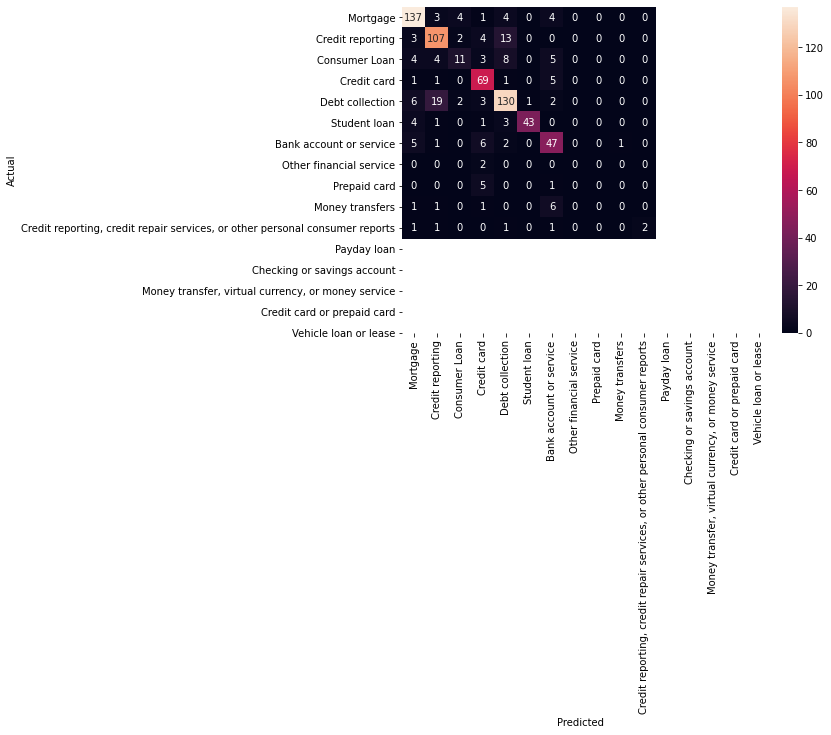

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from IPython.display import display

for predicted in category_id_df.cat_id:
  for actual in category_id_df.cat_id:
    if predicted != actual and conf_mat[actual, predicted] >= 4:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer complaint narrative']])
      print('')

'Consumer Loan' predicted as 'Mortgage' : 4 examples.


,Product,Consumer complaint narrative
4749,Consumer Loan,Check out XXXXfor detailed descriptions on how...
862,Consumer Loan,I have a vehicle loan with Santander Consumer....
4372,Consumer Loan,This week I was presented an on line personal ...
6814,Consumer Loan,I was responding to UAC regarding an email tha...



'Debt collection' predicted as 'Mortgage' : 6 examples.


,Product,Consumer complaint narrative
2132,Debt collection,Around XX/XX/XXXX my wife and I lost all our i...
4482,Debt collection,I canceled my cable with XXXX last year in 201...
1414,Debt collection,Submitted a complaint with multiple concerns t...
7318,Debt collection,M @ T bank keeps reporting late payment I had ...
398,Debt collection,I was contacted by a collection agency for def...
3926,Debt collection,"Payments were paid to XXXX funds, and my loan ..."



'Student loan' predicted as 'Mortgage' : 4 examples.


,Product,Consumer complaint narrative
2419,Student loan,"Private lender, expecting payments of XXXX a m..."
2586,Student loan,Wells Fargo charged off my student loan in err...
2957,Student loan,The amounts applied to principal and interest ...
5982,Student loan,Lost job loan went into default as I was secur...



'Bank account or service' predicted as 'Mortgage' : 5 examples.


,Product,Consumer complaint narrative
482,Bank account or service,I had a XXXX mortgage loan with XXXX XXXX. The...
2389,Bank account or service,My home suffered damage in a recent flood. The...
8476,Bank account or service,I opened a Line of Credit with Chase on XX/XX/...
9199,Bank account or service,Note : This Complaint was also filed through t...
7792,Bank account or service,"Simply, I am trying to locate and ascertain th..."


IndexError: ignored

In [ ]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Bank account or service':
  . Top unigrams:
       . bank
       . branch
  . Top bigrams:
       . debit card
       . sent money


IndexError: ignored

In [ ]:
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"I requested a home loan modification through Bank of America. Bank of America never got back to me."
  - Predicted as: 'Mortgage'

"It has been difficult for me to find my past due balance. I missed a regular monthly payment"
  - Predicted as: 'Mortgage'

"I can't get the money out of the country."
  - Predicted as: 'Bank account or service'

"I have no money to pay my tuition"
  - Predicted as: 'Debt collection'

"Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"
  - Predicted as: 'Bank account or service'



In [ ]:

from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Product'].unique()))

                         precision    recall  f1-score   support

       Credit reporting       0.85      0.90      0.87       153
          Consumer Loan       0.78      0.83      0.80       129
        Debt collection       0.58      0.31      0.41        35
               Mortgage       0.73      0.90      0.80        77
            Credit card       0.80      0.80      0.80       163
Other financial service       0.98      0.83      0.90        52
Bank account or service       0.66      0.76      0.71        62
           Student loan       0.00      0.00      0.00         2
        Money transfers       0.00      0.00      0.00         6
            Payday loan       0.00      0.00      0.00         9
           Prepaid card       1.00      0.33      0.50         6

               accuracy                           0.79       694
              macro avg       0.58      0.51      0.53       694
           weighted avg       0.77      0.79      0.77       694



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# as there is no or less data for some product so thats why f score for few product is 0